# Parameter Fitting

This example shows how to use Torch-EPG-X to perform parameter inference.

We will build on the previous example.

We'll generate an FSE dataset from IXI database.
We will neglect encoding and assume single coil for this case.

In [1]:
import numpy as np
import torchio as tio
import epgtorchx as epgx


ixi_dataset = tio.datasets.IXI(
    '/home/mcencini//ixi/',
    modalities=('PD','T1', 'T2'),
    download=False,
)

# get subject 0
sample_subject = ixi_dataset[0]


M0 = sample_subject.PD.numpy().astype(np.float32).squeeze()[:, :, 60].T
T2w = sample_subject.T2.numpy().astype(np.float32).squeeze()[:, :, 60].T

sa = np.sin(np.deg2rad(8.0))
ta = np.tan(np.deg2rad(8.0))

T2 = -92.0 / np.log(T2w/M0)
T2 = np.nan_to_num(T2, neginf=0.0, posinf=0.0)
T2 = np.clip(T2, a_min=0.0, a_max=np.inf)

M0 = np.flip(M0)
T2 = np.flip(T2)

def simulate(T2, flip, ESP, phases=None, device="cpu"):
    if phases is None:
        phases = -np.ones_like(flip) * 90.0
    
    # get ishape
    ishape = T2.shape   
    output = epgx.fse(flip, phases, ESP, 1000.0,  T2.flatten(), device=device)
    
    return abs(output.T.reshape(-1, *ishape))

/home/mcencini/.conda/envs/mrsim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_28622/1627281983.py:22: RuntimeWarning: divide by zero encountered in divide
  T2 = -92.0 / np.log(T2w/M0)
/tmp/ipykernel_28622/1627281983.py:22: RuntimeWarning: invalid value encountered in divide
  T2 = -92.0 / np.log(T2w/M0)
/tmp/ipykernel_28622/1627281983.py:22: RuntimeWarning: divide by zero encountered in log
  T2 = -92.0 / np.log(T2w/M0)


now generate the data

(<matplotlib.image.AxesImage at 0x7f1db9c41400>,
 (-0.5, 767.5, 255.5, -0.5),
 (-0.5, 767.5, 255.5, -0.5))

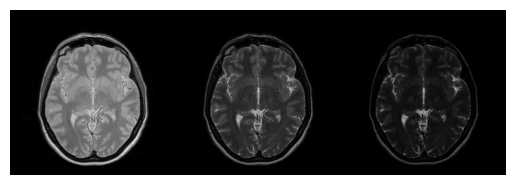

In [2]:
flip = 180.0 * np.ones(32, dtype=np.float32)
ESP = 5.0
device="cpu"

# simulate acquisition
echo_series = M0 * simulate(T2, flip.copy(), ESP, device=device)

# display
img = np.concatenate((echo_series[0], echo_series[16], echo_series[-1]), axis=1)

import matplotlib.pyplot as plt
plt.imshow(abs(img), cmap="gray"), plt.axis("image"), plt.axis("off")

now, we want to implement a simple dictionary based inference algorithm.
We first need a container to store the dictionary. We'll use Python dataclasses for this:

In [3]:
from dataclasses import dataclass

@dataclass
class BlochDictionary:
    atoms: np.ndarray
    lookup_table: np.ndarray
    labels: list

    def __post_init__(self):
        self.atoms = np.ascontiguousarray(self.atoms.transpose())
        self.norm = np.linalg.norm(self.atoms, axis=0)
        self.atoms = self.atoms / self.norm
        self.lookup_table = np.ascontiguousarray(self.lookup_table.transpose())
        self.labels = list(self.labels)

    def to(self, device):
        self.atoms = self.atoms.to(device)
        self.norm = self.norm.to(device)
        self.lookup_table = self.lookup_table.to(device)
        return self

Now, we implement a simple exhaustive search algorithm. We'll use Numba to parallelize it 
across different voxels:

In [4]:
import numba as nb

This is the main algorithm. We select matching entry using dot product
as a cost function:

In [5]:
def _matching(signals, atoms, labels):
    """
    performs pattern matching step.
    """
    # preallocate
    cost = np.zeros(signals.shape[0], dtype=np.complex64)
    idx = np.zeros(signals.shape[0], dtype=int)

    # do actual matching
    _dot_search(signals, atoms, cost, idx)

    return labels[:, idx], cost, idx

We need to implement the dot search:

In [6]:
@nb.njit(fastmath=True, parallel=True)  # pragma: no cover
def _dot_search(time_series, dictionary, cost, idx):
    for n in nb.prange(time_series.shape[0]):
        for a in range(dictionary.shape[0]):
            value = _dot_product(time_series[n], dictionary[a])

            # keep maximum value
            if np.abs(value) > np.abs(cost[n]):
                cost[n] = value
                idx[n] = a

Here, we implement a trivial dot product, compatible with numba:

In [7]:
@nb.njit(fastmath=True, cache=True)  # pragma: no cover
def _dot_product(x, y):
    z = 0.0
    for n in range(x.shape[0]):
        z += x[n] * y[n]

    return z

We now create a wrapper to handle arbitrarily shaped inputs:

In [8]:
def matching(bloch_dict, time_series):
    shape = time_series.shape[1:]
    time_series = time_series.reshape((time_series.shape[0], np.prod(shape)))
    time_series = np.ascontiguousarray(time_series.transpose().conj())

    # get atoms
    atoms = np.ascontiguousarray(bloch_dict.atoms.transpose())
    labels = bloch_dict.lookup_table

    # get quantitative maps and proton density
    qmaps, cost, idx = _matching(time_series, atoms, labels)
    qmaps = qmaps.reshape([qmaps.shape[0]] + list(shape))
    qmaps = [qmap for qmap in qmaps]
    m0 = (cost / bloch_dict.norm[idx]).reshape(shape)

    return m0, dict(zip(bloch_dict.labels, qmaps))

We can assume the above code to be in a library. We now want to 
integrate it with our signal model from epg-torch-x. This can be done as:

In [9]:
import torch

def fse_fit(input, t2grid, flip, ESP, phases=None):
    if isinstance(input, torch.Tensor):
        istorch = True
        device = input.device
        input = input.numpy(force=True)
    else:
        istorch = False

    # default
    if phases is None:
        phases = -np.ones_like(flip) * 90.0

    # first build grid
    t2lut = np.linspace(t2grid[0], t2grid[1], t2grid[2])
    t1 = 1000.0

    # build dictionary
    atoms = epgx.fse(flip, phases, ESP, t1, t2lut)
    blochdict = BlochDictionary(atoms, t2lut[:, None], ["T2"])

    # perform matching
    m0, maps = matching(blochdict, input)

    # here, we only have T2
    t2map = maps["T2"]

    # cast back
    if istorch:
        m0 = torch.as_tensor(m0, device=device)
        t2map = torch.as_tensor(t2map, device=device)

    return m0, t2map

Done! We can now try it:

(<matplotlib.image.AxesImage at 0x7f1db0a43b90>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'recon M0'))

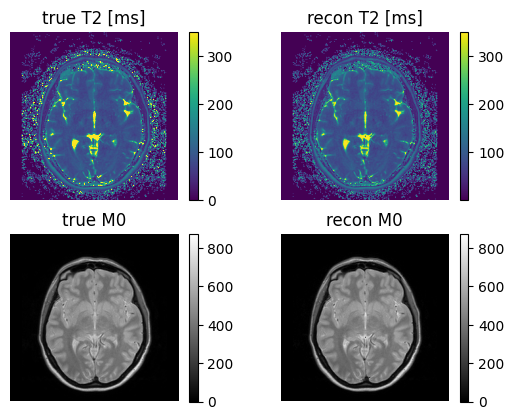

In [10]:
M0rec, T2rec = fse_fit(echo_series.copy(), (1.0, 350.0, 1000), flip.copy(), ESP)

plt.subplot(2,2,1)
plt.imshow(T2, vmax=350.0), plt.axis("off"), plt.colorbar(), plt.title("true T2 [ms]")
plt.subplot(2,2,2)
plt.imshow(T2rec, vmax=350.0), plt.axis("off"), plt.colorbar(), plt.title("recon T2 [ms]")
plt.subplot(2,2,3)
plt.imshow(M0, cmap="gray"), plt.axis("off"), plt.colorbar(), plt.title("true M0")
plt.subplot(2,2,4)
plt.imshow(abs(M0rec), cmap="gray"), plt.axis("off"), plt.colorbar(), plt.title("recon M0")